In [1]:
import sympy as sym

import numpy as np

import itertools

sym.init_printing()

In [76]:
from importlib.machinery import SourceFileLoader


main = SourceFileLoader("main", "src/main.py").load_module()

**Defining variables**

In [3]:
y_1, p_1, q_1 = sym.symbols("y_1, p_1, q_1")
y_2, p_2, q_2 = sym.symbols("y_2, p_2, q_2")

In [4]:
s_one = (y_1, p_1, q_1)
s_two = (y_2, p_2, q_2)

In [5]:
s_one

**Get expression using code**

In [6]:
d = sym.symbols("delta")

In [8]:
v_zero = main.expected_distribution_opening_round(s_one, s_two)

In [9]:
v_zero

In [11]:
M = main.markov_chain_for_reactive_strategies(s_one, s_two)

In [12]:
inverse = sym.Matrix(np.identity(4) - d * M).inverse_ADJ()

In [13]:
inverse = inverse.applyfunc(sym.simplify)

In [14]:
expression = (1 - d) * sym.Matrix(v_zero).reshape(1, 4) @ inverse

**Check the written mathematics**

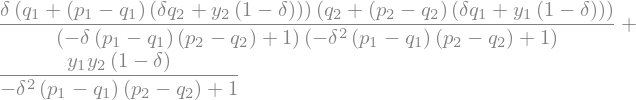

In [15]:
u_R = main.probability_being_in_state_R(s_one, s_two, d)
u_R

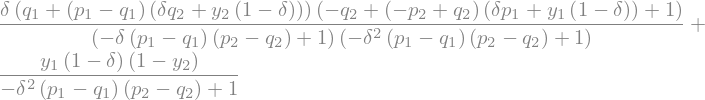

In [25]:
u_S = main.probability_being_in_state_S(s_one, s_two, d)
u_S

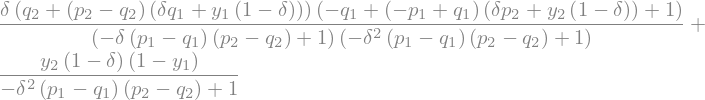

In [17]:
u_T = main.probability_being_in_state_T(s_one, s_two, d)
u_T

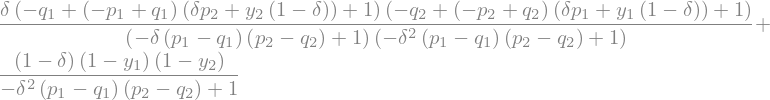

In [18]:
u_P = main.probability_being_in_state_P(s_one, s_two, d)
u_P

In [27]:
(u_R - expression[0]).simplify(), (u_S - expression[1]).factor()

In [28]:
(u_T - expression[2]).factor(), (u_P - expression[3]).factor()

**Check functions for analysis of ALLD into GTFT**

In [41]:
q = sym.symbols("q")

N, k = sym.symbols("N, k")

In [42]:
ALLD = (0, 0, 0)
GTFT = (1, 1, q)

**States of Eq. (9) and (10)**

In [44]:
main.probability_being_in_state_R(GTFT, GTFT, d).factor()

In [45]:
main.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [46]:
main.probability_being_in_state_R(GTFT, ALLD, d).factor()

In [47]:
main.probability_being_in_state_T(ALLD, GTFT, d).factor()

In [48]:
(
    main.probability_being_in_state_S(GTFT, GTFT, d).factor(),
    main.probability_being_in_state_T(GTFT, GTFT, d).factor(),
    main.probability_being_in_state_P(GTFT, GTFT, d).factor(),
)

In [49]:
main.probability_being_in_state_R(ALLD, GTFT, d).factor(), main.probability_being_in_state_S(
    ALLD, GTFT, d
).factor()

In [50]:
main.probability_being_in_state_T(ALLD, GTFT, d).factor(), main.probability_being_in_state_P(
    ALLD, GTFT, d
).factor()

**Ep. (11)**

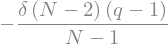

In [69]:
main.probability_of_receving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_R,
    opponent_state=main.probability_being_in_state_P,
    N=N,
    k=1,
    delta=d,
).factor()

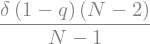

In [70]:
main.probability_of_receving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_R,
    opponent_state=main.probability_being_in_state_P,
    N=N,
    k=1,
    delta=d,
).factor().collect(1 - q)

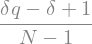

In [71]:
main.probability_of_receving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_S,
    opponent_state=main.probability_being_in_state_T,
    N=N,
    k=1,
    delta=d,
).factor()

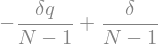

In [72]:
main.probability_of_receving_payoffs(
    player=GTFT,
    opponent=ALLD,
    player_state=main.probability_being_in_state_P,
    opponent_state=main.probability_being_in_state_P,
    N=N,
    k=1,
    delta=d,
).expand()

**Fixation probabilities**

In [73]:
R, S, T, P = sym.symbols('R, S, T, P')

In [74]:
b = sym.symbols('beta')
b

In [79]:
expr = (main.probability_mutant_increases(GTFT, ALLD, N, k=1, delta=d, beta=b, payoffs=[R, S, T, P]) /
        main.probability_mutant_descreases(GTFT, ALLD, N, k=1, delta=d, beta=b, payoffs=[R, S, T, P]))


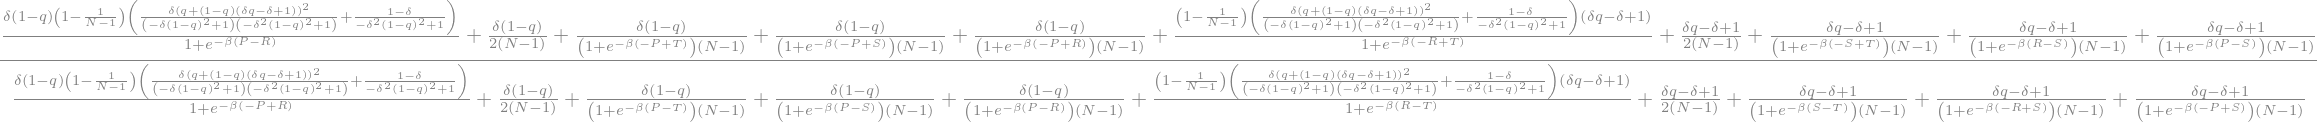

In [80]:
expr